# **Lojistik Regresyon ile Diyabet Tahmini**
### **İş Problemi :**

* Özellikleri belirtildiğinde kişilerin diyabet hastası olup olmadıklarını tahmin edebilecek bir makine öğrenmesi modeli geliştirebilir misiniz?

* Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır. ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları üzerinde yapılan diyabet araştırması için kullanılan verilerdir. 

* 768 gözlem ve 8 sayısal bağımsız değişkenden oluşmaktadır. Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.

**Değişkenler**

* **Pregnancies:** Hamilelik sayısı

* **Glucose:** Glikoz

* **BloodPressure:** Kan basıncı

* **SkinThickness:** Cilt Kalınlığı

* **Insulin:** İnsülin.

* **BMI:** Beden kitle indeksi

* **DiabetesPedigreeFunction:** Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon

* **Age:** Yaş (yıl)

* **Outcome:** Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [3]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

*  **Exploratory Data Analysis**

In [4]:
df = pd.read_csv("/content/drive/MyDrive/DSMLBC10/week_11 (08.12.22-14.12.22)/dataset/diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

* **Target'ın Analizi**

In [7]:
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [8]:
100 * df["Outcome"].value_counts() / len(df)

0   65.104
1   34.896
Name: Outcome, dtype: float64

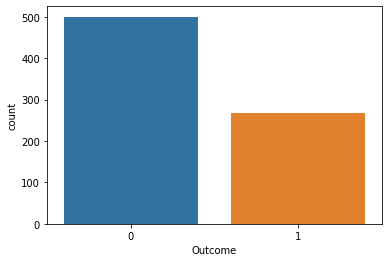

In [9]:
sns.countplot(x="Outcome", data=df)
plt.show()

* **Feature'ların Analizi**

In [10]:
def plot_numerical_col(dataframe, numerical_col):
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.show(block=True)

#for col in df.columns:
#    plot_numerical_col(df, col)

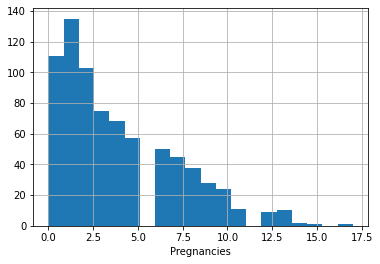

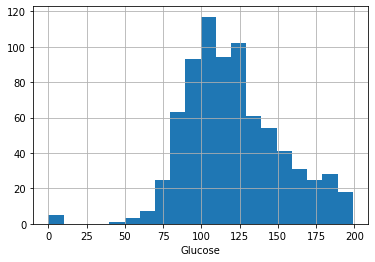

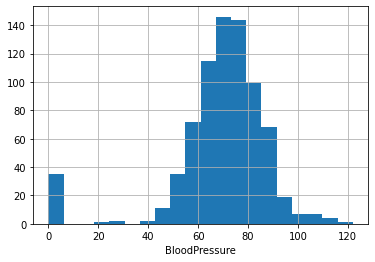

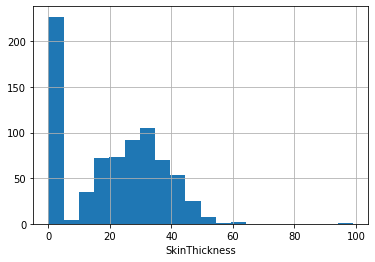

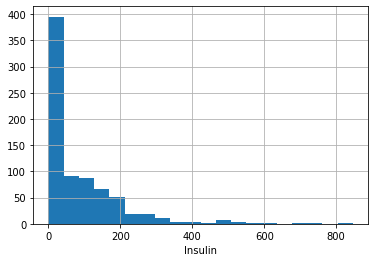

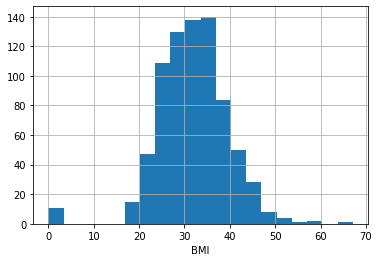

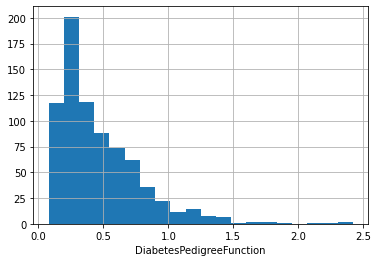

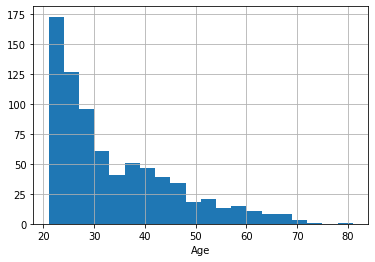

In [11]:
cols = [col for col in df.columns if "Outcome" not in col]

for col in cols:
  plot_numerical_col(df, col)

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


* Glucose, BloodPressure, SkinThickness, Insulin ve BMI değerlerinin 0 olması anlamsızdır. Dolayısıyla karar alırken bunu göze alarak inceleme yapılmalıdır.

* **Target vs Features**

In [13]:
df.groupby("Outcome").agg({"Pregnancies": "mean"})

,Pregnancies
Outcome,
0,3.298
1,4.866


In [14]:
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [15]:
for col in cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




* Hedef değişken ile bağımsız değişkenler arasındaki ilişki gözlemlenmiştir.

In [16]:
replace_with_thresholds(df, "Insulin")

In [17]:
for col in cols:
    df[col] = RobustScaler().fit_transform(df[[col]])

* Değerleri daha büyük olanın daha küçük olana göre bir üstünlüğü olmaması için bir standartlaştırma işlemi yapılmalıdır. 

* Kullanılan parametre tahmin yöntemlerinin daha hızlı ve daha doğru tahminlerde bulunması için standartlaştırma yapılmalıdır. 

* RobustScaler aykırı değerlerden etkilenmez, dayanıklıdır. Medyan kullanır ki medyanda aykırı değerlerden etkilenmez. 

In [18]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1


* **Model & Prediction**

In [19]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X, y)

In [20]:
log_model.intercept_ # beta = sabit
log_model.coef_  # bağımsız değişkenlerin katsayıları, ağırlıkları

y_pred = log_model.predict(X)

In [21]:
y_pred[0:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0])

In [22]:
y[0:10]

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

* **Model Evaluation**

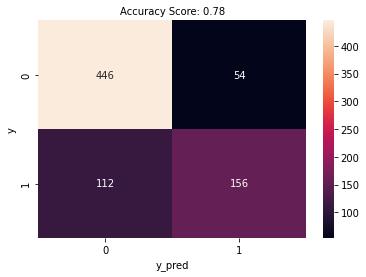

In [23]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred)

In [24]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.58      0.65       268

    accuracy                           0.78       768
   macro avg       0.77      0.74      0.75       768
weighted avg       0.78      0.78      0.78       768



In [25]:
y_prob = log_model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

0.8393955223880598

* **Model Validation: Holdout**

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=17)
log_model = LogisticRegression().fit(X_train, y_train)
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        97
           1       0.79      0.53      0.63        57

    accuracy                           0.77       154
   macro avg       0.78      0.72      0.73       154
weighted avg       0.78      0.77      0.76       154



/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


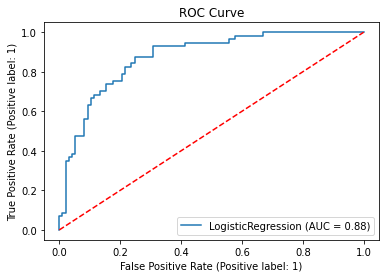

In [27]:
plot_roc_curve(log_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [28]:
roc_auc_score(y_test, y_prob)

0.8755652016639537

* **Model Validation: 10-Fold Cross Validation**

In [29]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

log_model = LogisticRegression().fit(X, y)

cv_results = cross_validate(log_model,
                            X, y,
                            cv=10,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [30]:
cv_results['test_accuracy'].mean()

0.7721804511278195

In [31]:
cv_results['test_precision'].mean()

0.7314932728090622

In [32]:
cv_results['test_recall'].mean()

0.5596866096866095

In [33]:
cv_results['test_f1'].mean()

0.6314298154545237

In [34]:
cv_results['test_roc_auc'].mean()

0.8301623931623932

* **Prediction for A New Observation**

In [35]:
X.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], dtype='object')

In [37]:
random_user = X.sample(1, random_state=45)
random_user

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
195,0.400,0.994,0.667,0.562,1.411,0.796,0.059,0.000


In [38]:
log_model.predict(random_user)

array([1])

* Lojistik regresyon modelinde kullanılmak üzere rasgele bir kullanıcı alındı, diyabet mi? diyabet değil mi? sorularının yanıtı aranıyor. Sonuç 1 çıktığı için bu kullanıcı diyabettir şeklinde yorumlanır. 